In [2]:
%matplotlib inline

import multiprocessing
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from itertools import islice

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import LagTransformerEstimator

In [4]:
dataset = get_dataset("electricity")

In [5]:
estimator = LagTransformerEstimator(
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        
        scaling="std",
        
        nhead=2,
        num_encoder_layers=4,
        num_decoder_layers=2,
        dim_feedforward=16,
        activation="gelu",
        
        batch_size=256,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=50),
    )

In [14]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        cache_data=True,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because self.layers[0].norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validatio

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 5.85249 (best 5.85249), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_9/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.41427 (best 5.41427), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_9/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.22122 (best 5.22122), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_9/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.16508 (best 5.16508), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_9/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 5.13231 (best 5.13231), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-t

In [15]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [16]:
forecasts = list(forecast_it)

In [9]:
tss = list(ts_it)

In [17]:
# num_workers is limited to 10 if cpu has more cores
num_workers = min(multiprocessing.cpu_count(), 10)

evaluator = Evaluator(num_workers=num_workers)

In [18]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))


Running evaluation: 2247it [00:00, 27642.91it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eva

In [19]:
agg_metrics

{'MSE': 1699353.3605744469,
 'abs_error': 7915254.201302687,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.673017229115215,
 'MAPE': 0.0925330129097111,
 'sMAPE': 0.09874831644566463,
 'MSIS': 5.436230429382124,
 'QuantileLoss[0.1]': 3191534.9403455807,
 'Coverage[0.1]': 0.08442738466102952,
 'QuantileLoss[0.2]': 5158144.203989559,
 'Coverage[0.2]': 0.1815198041833556,
 'QuantileLoss[0.3]': 6537250.36521844,
 'Coverage[0.3]': 0.2831367749592048,
 'QuantileLoss[0.4]': 7449845.689399119,
 'Coverage[0.4]': 0.3864040943480196,
 'QuantileLoss[0.5]': 7915254.207095364,
 'Coverage[0.5]': 0.49195223260643817,
 'QuantileLoss[0.6]': 7986841.531431158,
 'Coverage[0.6]': 0.5835929387331257,
 'QuantileLoss[0.7]': 7462329.538075933,
 'Coverage[0.7]': 0.6905689066904019,
 'QuantileLoss[0.8]': 6362337.498570402,
 'Coverage[0.8]': 0.7890149829402165,
 'QuantileLoss[0.9]': 4403064.440043806,
 'Coverage[0.9]': 0.8873127132472927,


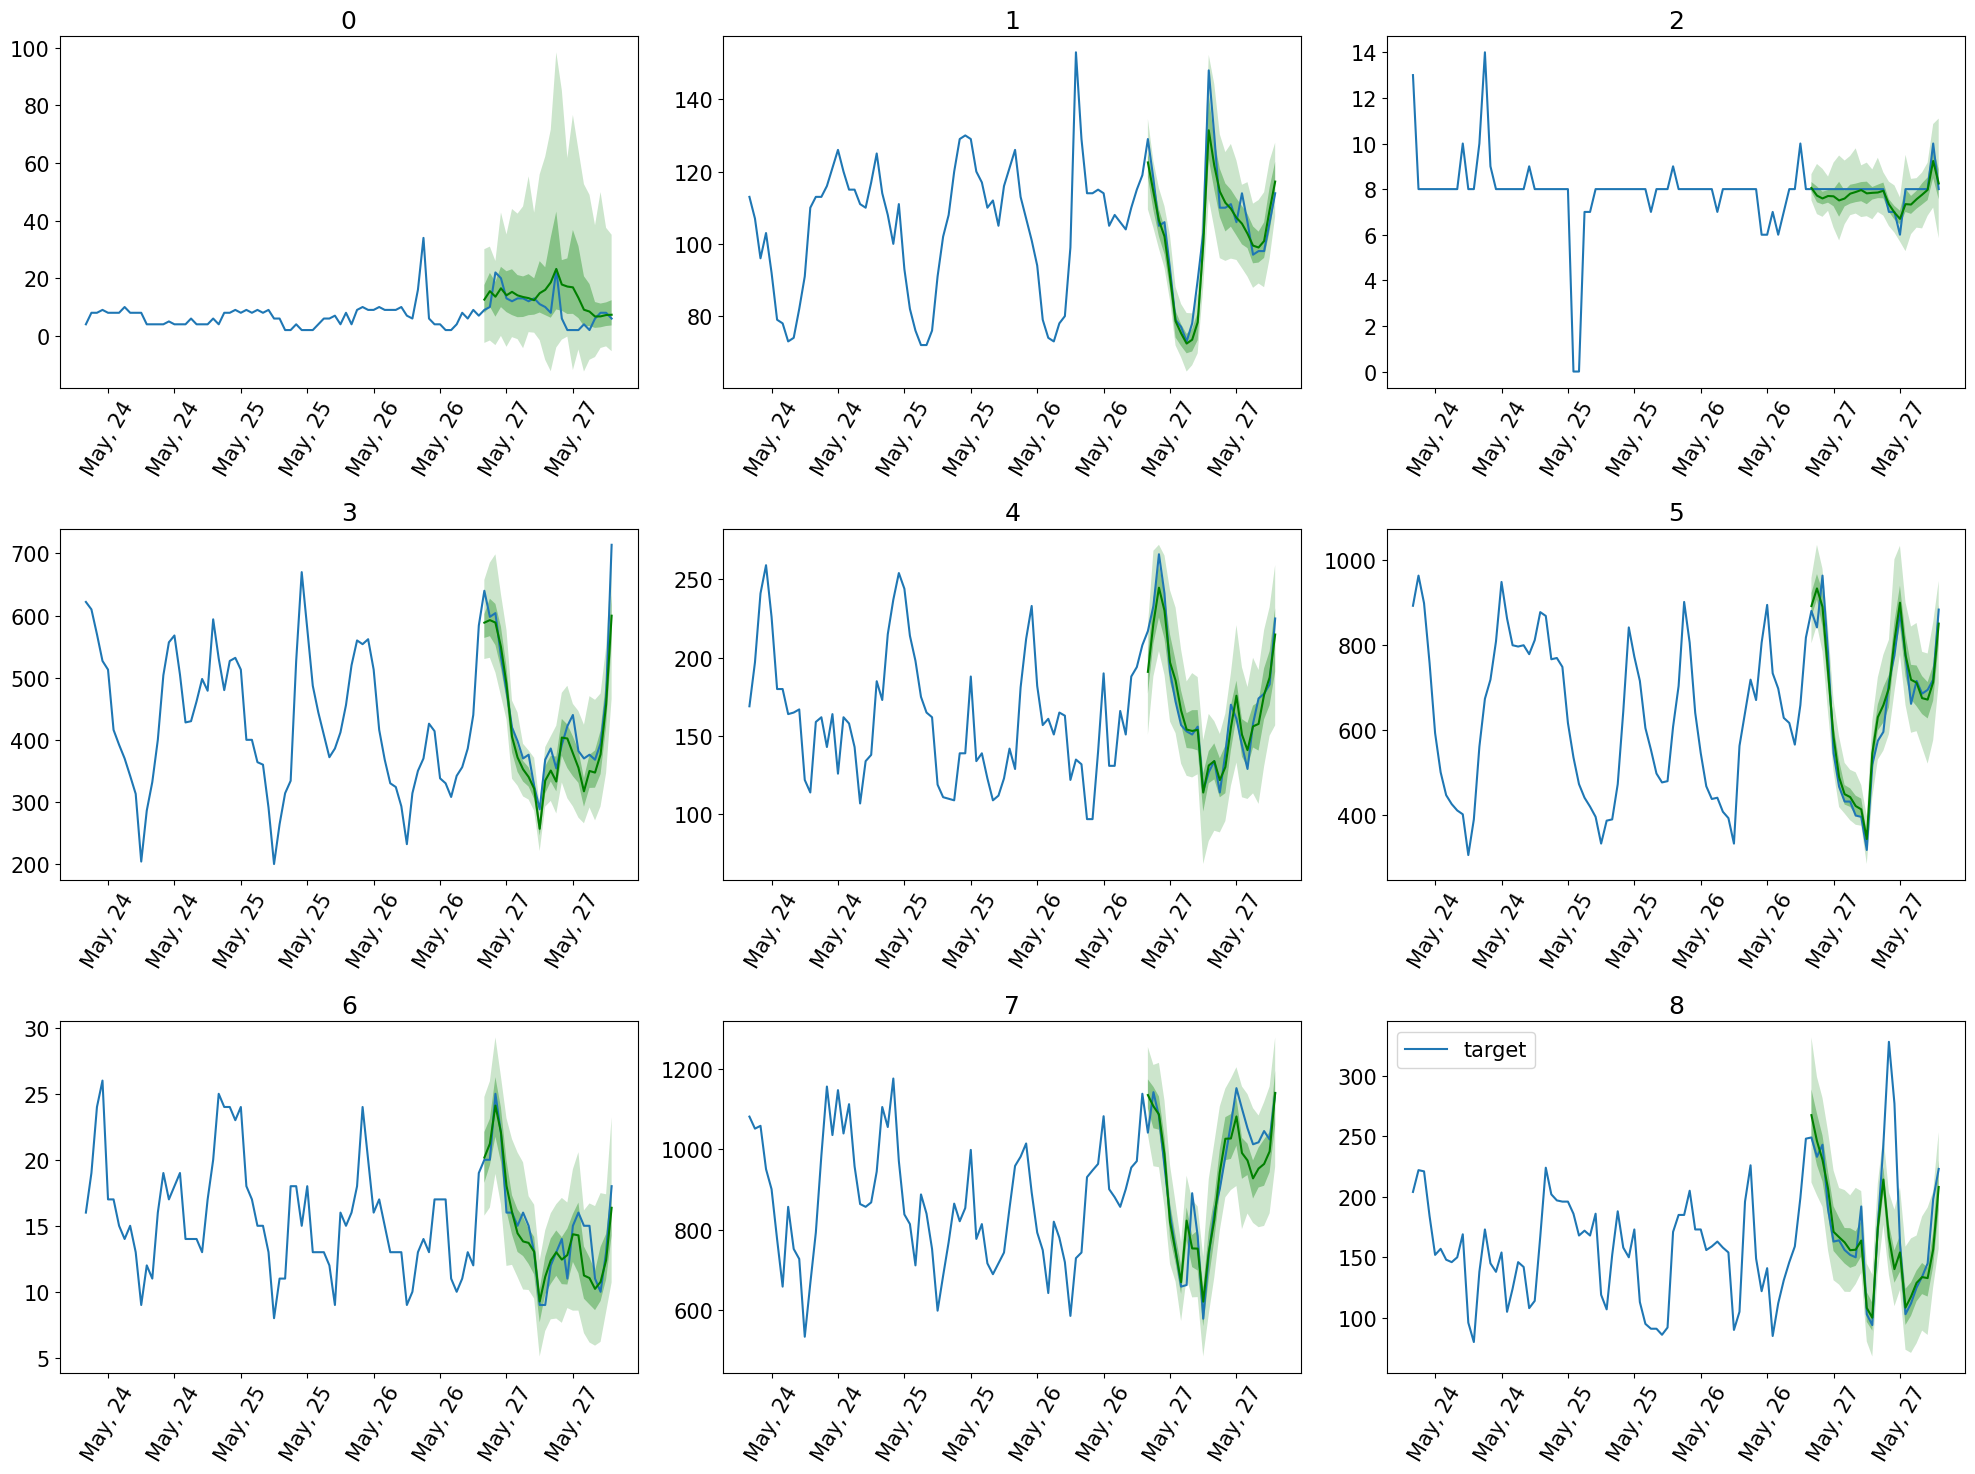

In [20]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()